In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import random
import cv2
from captcha.image import ImageCaptcha#导入captchaimage

#从txt中读取label，并用str格式打开并存入numpy数组
data = np.genfromtxt('train/labels.txt',dtype='str')
label=data[:,0]

width,height, n_len,n_class=180, 60, 7, 16

#定义数字符号与括号
number = '0123456789'
sign  ='+-*'
bracket = '()'
characters = number + sign + bracket+' '

#定义解码函数
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]#寻找每一个y中最大的概率值，这个概率值对应的字符就是解码的字符
    return ''.join([characters[x] for x in y])#在字符列表中找到这些字符并返回

In [2]:
def random_str():
    ts = ['{}{}{}{}{}', '({}{}{}){}{}', '{}{}({}{}{})'] #会出现的三种运算式模式
    ds = u'0123456789' #可能出现的数字
    os = u'+-*'        #可能出现的运算符
    #利用下标确定是数字还是运算符，如果下标是偶数则为数字，奇数则为运算符
    cs = [random.choice(ds) if x%2 == 0 else random.choice(os) for x in range(5)] 
    return random.choice(ts).format(*cs)

In [7]:
a=random_str()
a

'9+2+7'

Reference: https://docs.python.org/2/library/string.html 7.1.3.2 Format examples

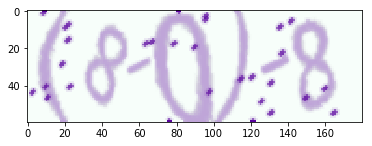

In [4]:
generator = ImageCaptcha(width=width, height=height)
img = generator.generate_image('(8-0)-8')
plt.imshow(img)
plt.show()

In [3]:
def gen(batch_size=32):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            gen_str = random_str()
            X[i]= np.array(generator.generate_image(gen_str)).transpose(1,0,2) 
           
            if len(gen_str) <7:
                gen_str +='  '
                
            y[i] = [characters.find(x) for x in gen_str]
                
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), 
               np.ones(batch_size)*n_len], np.ones(batch_size)

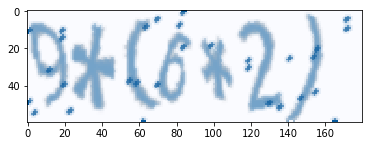

In [24]:
[x,y,_,_],_=next(gen(1))
plt.imshow(x[0].transpose(1,0,2))
plt.show()

In [4]:
from keras import backend as K
from keras.models import *
from keras.layers import *

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [5]:
input_tensor = Input((width, height, 3))
x = input_tensor
rnn_size = 128
x = Conv2D(16, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(16, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(padding="same", pool_size=(2, 2))(x)
    
x = Conv2D(32, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(padding="same", pool_size=(2, 2))(x)
    
x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(padding="same", pool_size=(2, 2))(x)
    
    
x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(padding="same", pool_size=(2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru1_b')(x)
gru1_merged = merge([gru_1, gru_1b], mode='sum')

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru2_b')(gru1_merged)
x = merge([gru_2, gru_2b], mode='concat')
x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')


/home/carnd/anaconda3/envs/match/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/home/carnd/anaconda3/envs/match/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/home/carnd/anaconda3/envs/match/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/carnd/anaconda3/envs/match/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/carnd/anaconda3/envs/

In [6]:
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen(128)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :7]
        out[out==-1]=15       
        batch_acc += ((y_test == out).sum(axis=1) == 7).mean()
        
    return batch_acc / batch_num

In [7]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print(' acc: %f%%'%acc)

evaluator = Evaluate()

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

callbacks = [   evaluator,            
                EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                
]
log = model.fit_generator(gen(64), steps_per_epoch=2000, epochs=50,
                    callbacks=callbacks,
                    validation_data=gen(64), validation_steps=100)

Epoch 1/50
2000/2000 [==============================] - 635s - loss: 1.3729 - val_loss: 0.9175
Epoch 2/50
2000/2000 [==============================] - 624s - loss: 0.5818 - val_loss: 0.6349
Epoch 3/50
2000/2000 [==============================] - 626s - loss: 0.5808 - val_loss: 1.0899
Epoch 4/50
2000/2000 [==============================] - 629s - loss: 0.5899 - val_loss: 0.6438
Epoch 5/50
2000/2000 [==============================] - 628s - loss: 0.5769 - val_loss: 0.5949
Epoch 6/50
2000/2000 [==============================] - 630s - loss: 0.5764 - val_loss: 0.6365
Epoch 7/50
2000/2000 [==============================] - 627s - loss: 0.5812 - val_loss: 0.7747
Epoch 8/50
2000/2000 [==============================] - 626s - loss: 0.5880 - val_loss: 0.6084
Epoch 9/50
2000/2000 [==============================] - 627s - loss: 0.5711 - val_loss: 0.6512
Epoch 10/50
2000/2000 [==============================] - 625s - loss: 0.5678 - val_loss: 0.6201
Epoch 11/50
2000/2000 [==========================

In [9]:
base_model.save("cap_ctc1.h5")

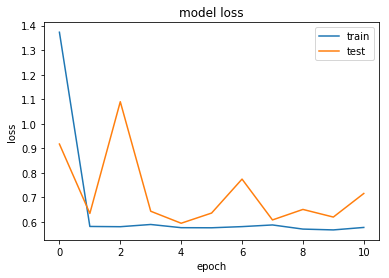

In [10]:
#过程可视化
import matplotlib.pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [11]:
from keras.optimizers import Adam
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=1e-5))
log = model.fit_generator(gen(64), steps_per_epoch=1500, epochs=50,
                    callbacks=callbacks,
                    validation_data=gen(64), validation_steps=100)

Epoch 1/50
1500/1500 [==============================] - 491s - loss: 0.5809 - val_loss: 0.6082
Epoch 2/50
1500/1500 [==============================] - 484s - loss: 0.5460 - val_loss: 0.5472
Epoch 3/50
1500/1500 [==============================] - 484s - loss: 0.5592 - val_loss: 0.5832
Epoch 4/50
1500/1500 [==============================] - 482s - loss: 0.5570 - val_loss: 0.5954
Epoch 5/50
1500/1500 [==============================] - 485s - loss: 0.5532 - val_loss: 0.5572
Epoch 6/50
1500/1500 [==============================] - 482s - loss: 0.5132 - val_loss: 0.4926
Epoch 7/50
1500/1500 [==============================] - 478s - loss: 0.2492 - val_loss: 0.2895
Epoch 8/50
1500/1500 [==============================] - 483s - loss: 0.5695 - val_loss: 0.5888
Epoch 9/50
1500/1500 [==============================] - 482s - loss: 0.5396 - val_loss: 0.5902
Epoch 10/50
1500/1500 [==============================] - 483s - loss: 0.5479 - val_loss: 0.5667
Epoch 11/50
1500/1500 [==========================

KeyboardInterrupt: 

In [12]:
base_model.save("cap_ctc2.h5")

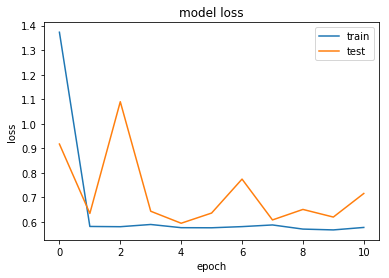

In [13]:
#过程可视化
import matplotlib.pyplot as plt
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()